# Import libraries

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error
from boruta import BorutaPy
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Configuration

In [2]:
COL_NAMES = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Whole weight.1',
    'Whole weight.2',
    'Shell weight',
    'Rings']

NUMERICAL_COLS = ['Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Whole weight.1',
    'Whole weight.2',
    'Shell weight']

CATEGORICAL_COL = ["Sex"]
SEED = 42

fold = KFold(n_splits=10, shuffle=True, random_state=SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Functions

In [3]:
def test_function():
    pass

# Import data

In [4]:
# Train data from Kaggle
org_train = pd.read_csv('data/train.csv')

# Orginal data from UCI
org_data = pd.read_csv('data/abalone.data', header=None, names=COL_NAMES)

In [5]:
# Enrich dataset
org_train.drop('id', axis=1, inplace=True)
df_master = pd.concat([org_train, org_data])

# Leave the original data as is
df = df_master.copy()
df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# EDA

In [6]:
print(f'Before concat: {org_train.shape}, {org_data.shape}\n')
print(f'After concat: {df_master.shape}, {df.shape}')

Before concat: (90615, 9), (4177, 9)

After concat: (94792, 9), (94792, 9)


In [7]:
# View columns stats
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94792 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Whole weight.1  94792 non-null  float64
 6   Whole weight.2  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 7.2+ MB


## Null & Duplicates analysis

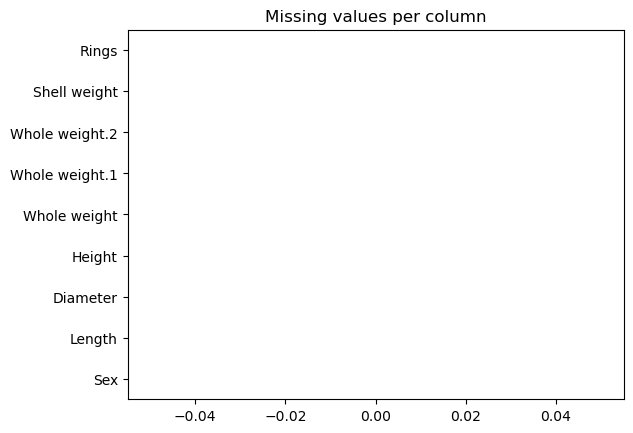

In [8]:
# Check for missing values with a horizontal bar plot
df.isnull().sum().plot(kind='barh')
plt.title('Missing values per column')
plt.show()

In [9]:
# Check for duplication
print(f'Number of duplicated records: {df.duplicated().sum()}')

Number of duplicated records: 0


## Categorical variables

In [10]:
# Select only categorical
categorical_columns = list(df.select_dtypes(include=['object']))
categorical_columns

['Sex']

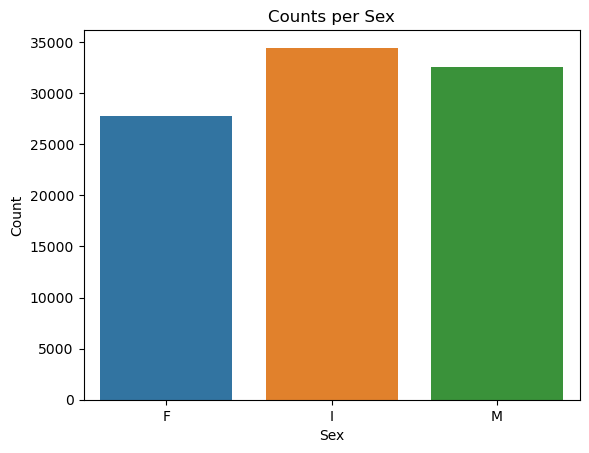

In [11]:
sns.countplot(data=df, x="Sex")
plt.title("Counts per Sex")
plt.ylabel("Count")
plt.show()

## Numerical variables

In [12]:
# Select only numerical
numerical_columns = list(df.select_dtypes(include=['float64', 'int64']))
numerical_columns

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings']

In [13]:
# Check statistics
df[numerical_columns].describe().round(3)

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000
mean,0.517,0.402,0.136,0.791,0.342,0.170,0.226,9.707
std,0.118,0.098,0.038,0.459,0.205,0.101,0.131,3.179
min,0.075,0.055,0.000,0.002,0.001,0.000,0.002,1.000
25%,0.445,0.345,0.110,0.420,0.178,0.086,0.120,8.000
50%,0.545,0.425,0.140,0.800,0.330,0.166,0.225,9.000
75%,0.600,0.470,0.160,1.072,0.464,0.233,0.305,11.000
max,0.815,0.650,1.130,2.826,1.488,0.760,1.005,29.000


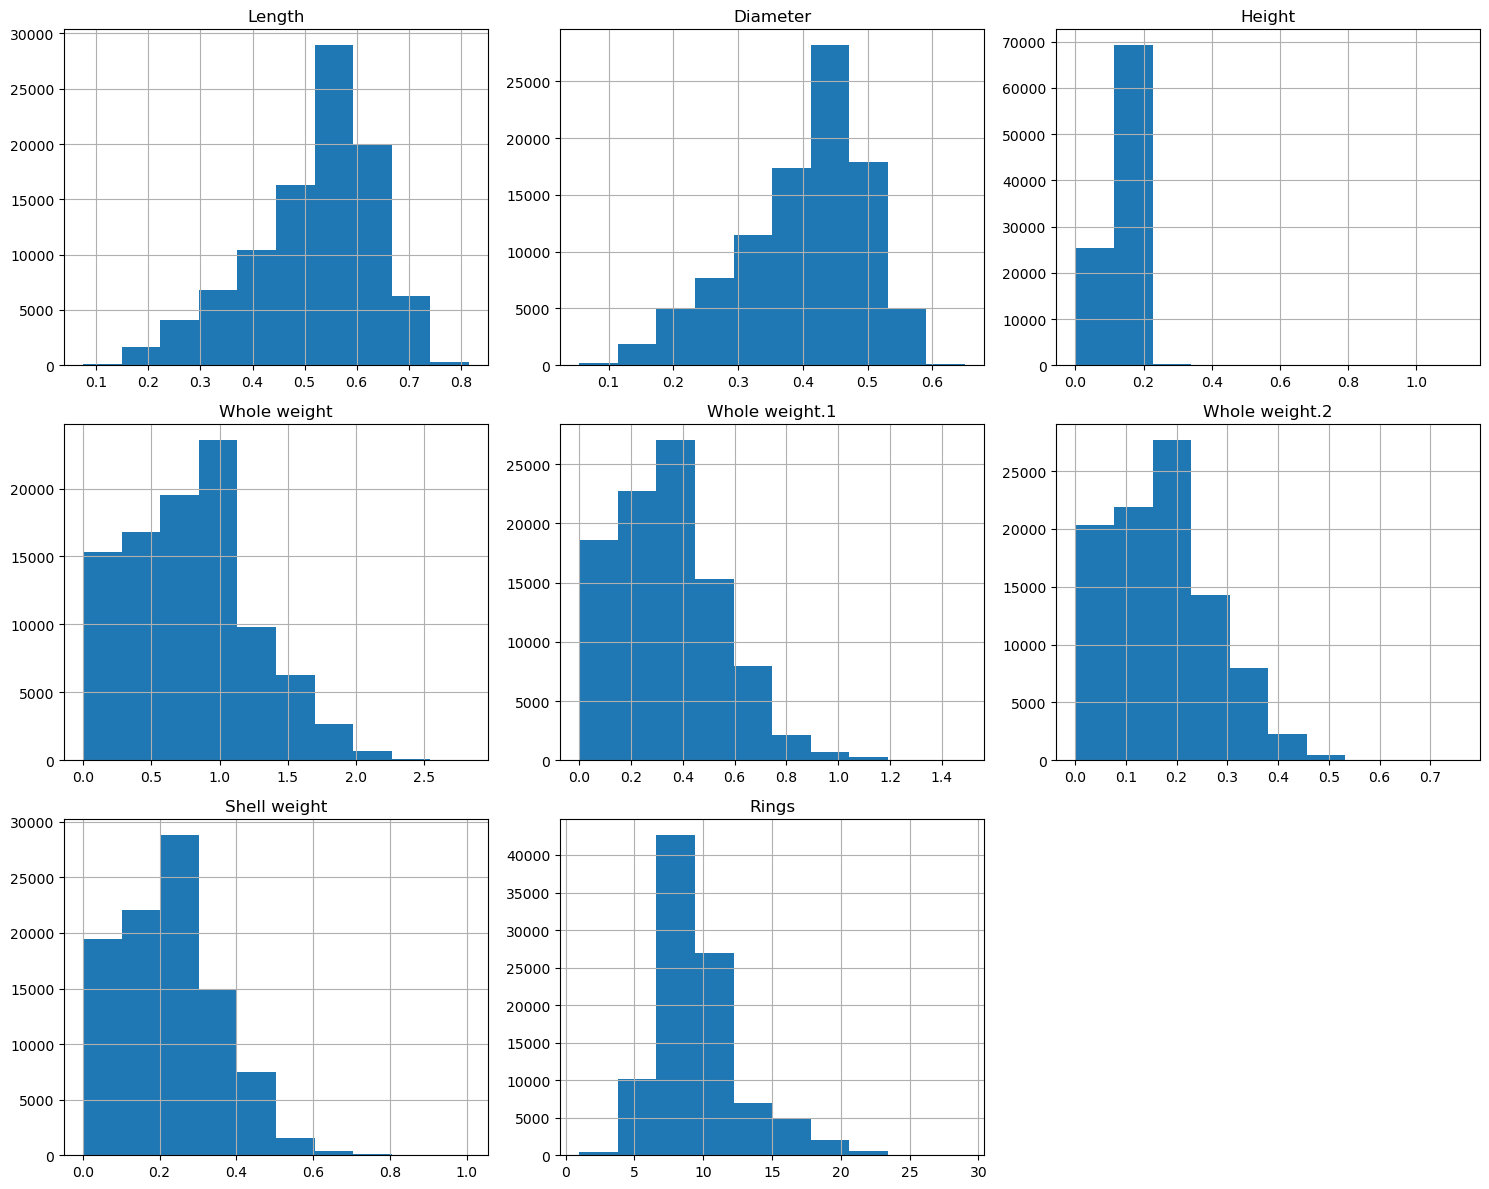

In [14]:
df.hist(figsize=(15, 12))
plt.tight_layout()
plt.show()

In [15]:
skew_coefficients = df[numerical_columns].skew()
skew_coefficients

Length           -0.727373
Diameter         -0.690925
Height            0.475841
Whole weight      0.436328
Whole weight.1    0.601075
Whole weight.2    0.485542
Shell weight      0.488303
Rings             1.200004
dtype: float64

## Correlation

In [16]:
# Create copy for correlation calculation
correlation_df = df.copy()

# Convert to use corr function
correlation_df.Sex = correlation_df.Sex.astype('category').cat.codes

# Create no target correlation matrix dataframe
no_target_df = correlation_df.drop('Rings', axis=1)

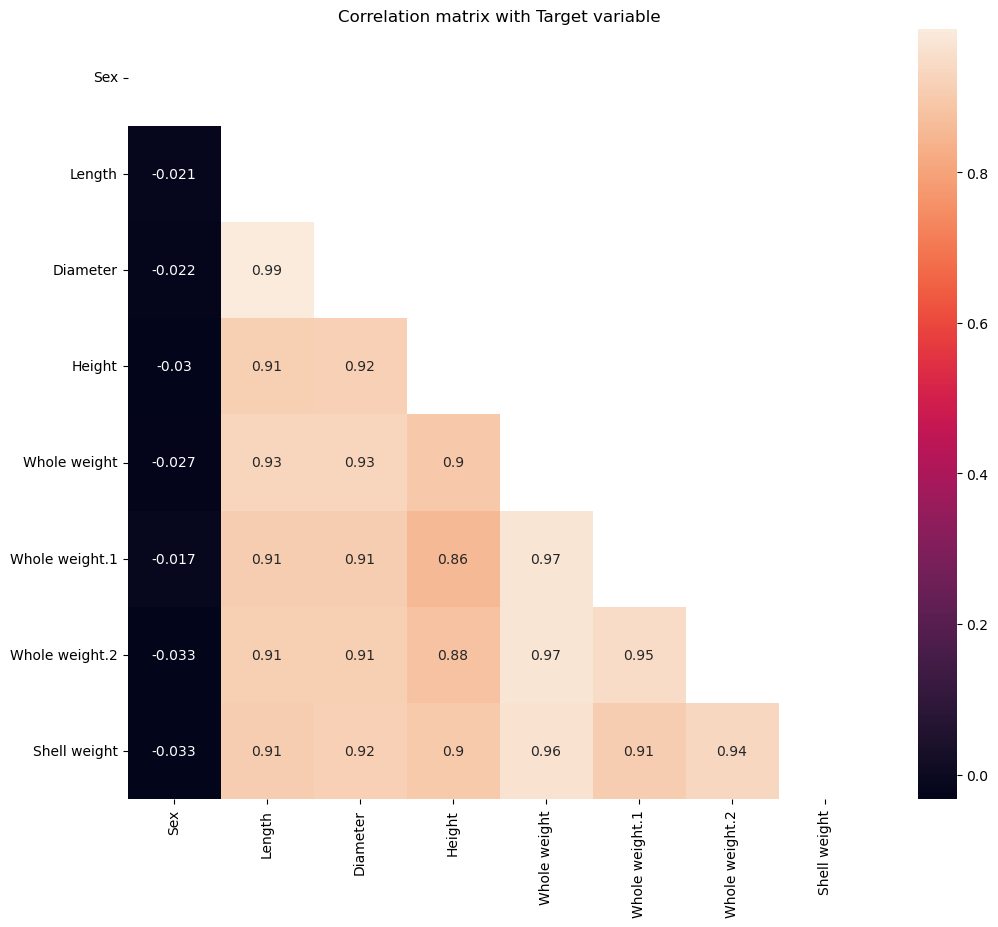

In [17]:
without_target_corr_matrix = no_target_df.corr()

# Create a mask for the upper triangle
mask_up_tri = np.triu(np.ones_like(without_target_corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(without_target_corr_matrix.round(3), annot=True, mask=mask_up_tri)
plt.title("Correlation matrix with Target variable")
plt.show()

In [18]:
# Calculate the correlation matrix with target
correlation_df.corr().abs()["Rings"].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.691610
Height            0.660468
Diameter          0.634092
Length            0.620809
Whole weight      0.613666
Whole weight.2    0.584903
Whole weight.1    0.510597
Sex               0.026677
Name: Rings, dtype: float64

# Pre-processing

In [19]:
features = df.drop('Rings', axis=1)
target = df['Rings']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED, stratify=target, shuffle=True
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (75833, 8), (75833,)
Test data shape: (18959, 8), (18959,)


# Feature engineering

In [21]:
processor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUMERICAL_COLS),
        ('cat', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COL)
    ], remainder='passthrough'
)

In [22]:
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

# Metric

The evaluation metric for this competition is the Root Mean Squared Logarithmic Error (RMSLE). 

The RMSLE is calculated as follows:

$$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\log(1+\hat{y}_i) - \log(1+y_i)\right)^2}$$

Where:
- $n \text{ is the total number of observations in the test set.}$
- $\hat{y}_i \text{ is the predicted value of the target for instance } i.$
- $y_i \text{ is the actual value of the target for instance } i.$
- $\log \text{ denotes the natural logarithm.}$

# Modeling

In [23]:
# Calculate gains
features_info_gain = mutual_info_classif(X_train_processed, y_train, random_state=SEED)

# Get the column names from the processor object
column_names = processor.get_feature_names_out(input_features=X_train.columns)

# Display information gain as a dataframe
info_gain_df = pd.DataFrame(features_info_gain, index=column_names, columns=['Information_Gain'])
info_gain_df.sort_values(by='Information_Gain', ascending=False, inplace=True)
info_gain_df

,Information_Gain
num__Shell weight,0.667512
num__Whole weight,0.569786
num__Height,0.543387
num__Diameter,0.535067
num__Whole weight.2,0.532627
num__Length,0.525005
num__Whole weight.1,0.499962
cat__Sex_I,0.232583
cat__Sex_F,0.074942
cat__Sex_M,0.060860


In [24]:
# Create regressors
xgb_reg = XGBRegressor(n_jobs=-1, random_state=SEED)
catboost_reg = CatBoostRegressor(random_state=SEED)
lgbm_reg = LGBMRegressor(random_state=SEED, n_jobs=-1)

## All features

In [25]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_reg, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with all features: {round(end_time - start_time, 2)} seconds")

Learning rate set to 0.079793
Learning rate set to 0.079794
Learning rate set to 0.079793
Learning rate set to 0.079793
Learning rate set to 0.079794
Learning rate set to 0.079794
Learning rate set to 0.079794
Learning rate set to 0.079794
0:	learn: 3.0557816	total: 71.1ms	remaining: 1m 11s
0:	learn: 3.0512907	total: 70.9ms	remaining: 1m 10s
0:	learn: 3.0524722	total: 71.1ms	remaining: 1m 11s
0:	learn: 3.0468450	total: 71.4ms	remaining: 1m 11s
0:	learn: 3.0567544	total: 71.1ms	remaining: 1m 11s
0:	learn: 3.0526689	total: 70.6ms	remaining: 1m 10s
0:	learn: 3.0544241	total: 70.5ms	remaining: 1m 10s
1:	learn: 2.9332430	total: 78.7ms	remaining: 39.3s
1:	learn: 2.9387297	total: 80.1ms	remaining: 40s
1:	learn: 2.9426455	total: 80.9ms	remaining: 40.3s
1:	learn: 2.9363210	total: 81.8ms	remaining: 40.8s
1:	learn: 2.9487303	total: 78.3ms	remaining: 39.1s
1:	learn: 2.9405981	total: 79.9ms	remaining: 39.8s
1:	learn: 2.9401607	total: 84.1ms	remaining: 42s
2:	learn: 2.8316174	total: 91.5ms	remaining

In [26]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
all_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
all_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
XGB,1.867
LightGBM,1.858
CatBoost,1.843


## Feature set using Information gain Feature selection

In [27]:
# Drop the least important feature
info_gain_features = features.drop("Sex", axis=1)

X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(info_gain_features, target, test_size=0.2, random_state=SEED, stratify=target, shuffle=True)

# Create a new processor
processor_ig = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUMERICAL_COLS)
    ], remainder='passthrough'
)

# Transform
X_train_ig_processed = processor_ig.fit_transform(X_train_ig)
X_test_ig_processed = processor_ig.transform(X_test_ig)

In [28]:
# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_reg, X_train_ig_processed, y_train_ig, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with Information gain features: {round(end_time - start_time, 2)} seconds")

Learning rate set to 0.079793
Learning rate set to 0.079793
Learning rate set to 0.079794
Learning rate set to 0.079793
0:	learn: 3.0521898	total: 37.5ms	remaining: 37.5s
Learning rate set to 0.079794
0:	learn: 3.0562796	total: 15.7ms	remaining: 15.7s
1:	learn: 2.9373848	total: 56.2ms	remaining: 28.1s
Learning rate set to 0.079794
2:	learn: 2.8363743	total: 65.4ms	remaining: 21.7s
Learning rate set to 0.079794
1:	learn: 2.9435371	total: 64ms	remaining: 31.9s
0:	learn: 3.0546288	total: 80ms	remaining: 1m 19s
0:	learn: 3.0509934	total: 52.1ms	remaining: 52s
0:	learn: 3.0490208	total: 89.4ms	remaining: 1m 29s
1:	learn: 2.9407018	total: 107ms	remaining: 53.2s
1:	learn: 2.9388323	total: 61.7ms	remaining: 30.8s
2:	learn: 2.8367607	total: 68ms	remaining: 22.6s
1:	learn: 2.9345996	total: 98.4ms	remaining: 49.1s
3:	learn: 2.7436337	total: 75.4ms	remaining: 18.8s
2:	learn: 2.8334025	total: 107ms	remaining: 35.7s
4:	learn: 2.6616254	total: 81.4ms	remaining: 16.2s
2:	learn: 2.8387074	total: 131ms	

In [29]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
info_gain_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
info_gain_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
XGB,1.878
LightGBM,1.866
CatBoost,1.853


## Feature set using Recursive feature elimination selection

In [30]:
# Base estimator for RFE
gb = GradientBoostingRegressor(random_state=SEED)

rmse_scores_list = []

# Loop to find the best number of features
for k in range(1, X_train_processed.shape[1] + 1):
    rfe = RFE(estimator=gb, n_features_to_select=k, step=1)
    rfe.fit(X_train_processed, y_train)

    X_train_rfe = rfe.transform(X_train_processed)
    X_test_rfe = rfe.transform(X_test_processed)

    gb.fit(X_train_rfe, y_train)
    rfe_pred = gb.predict(X_test_rfe)

    rsme = root_mean_squared_log_error(y_test, rfe_pred)
    rmse_scores_list.append(rsme)

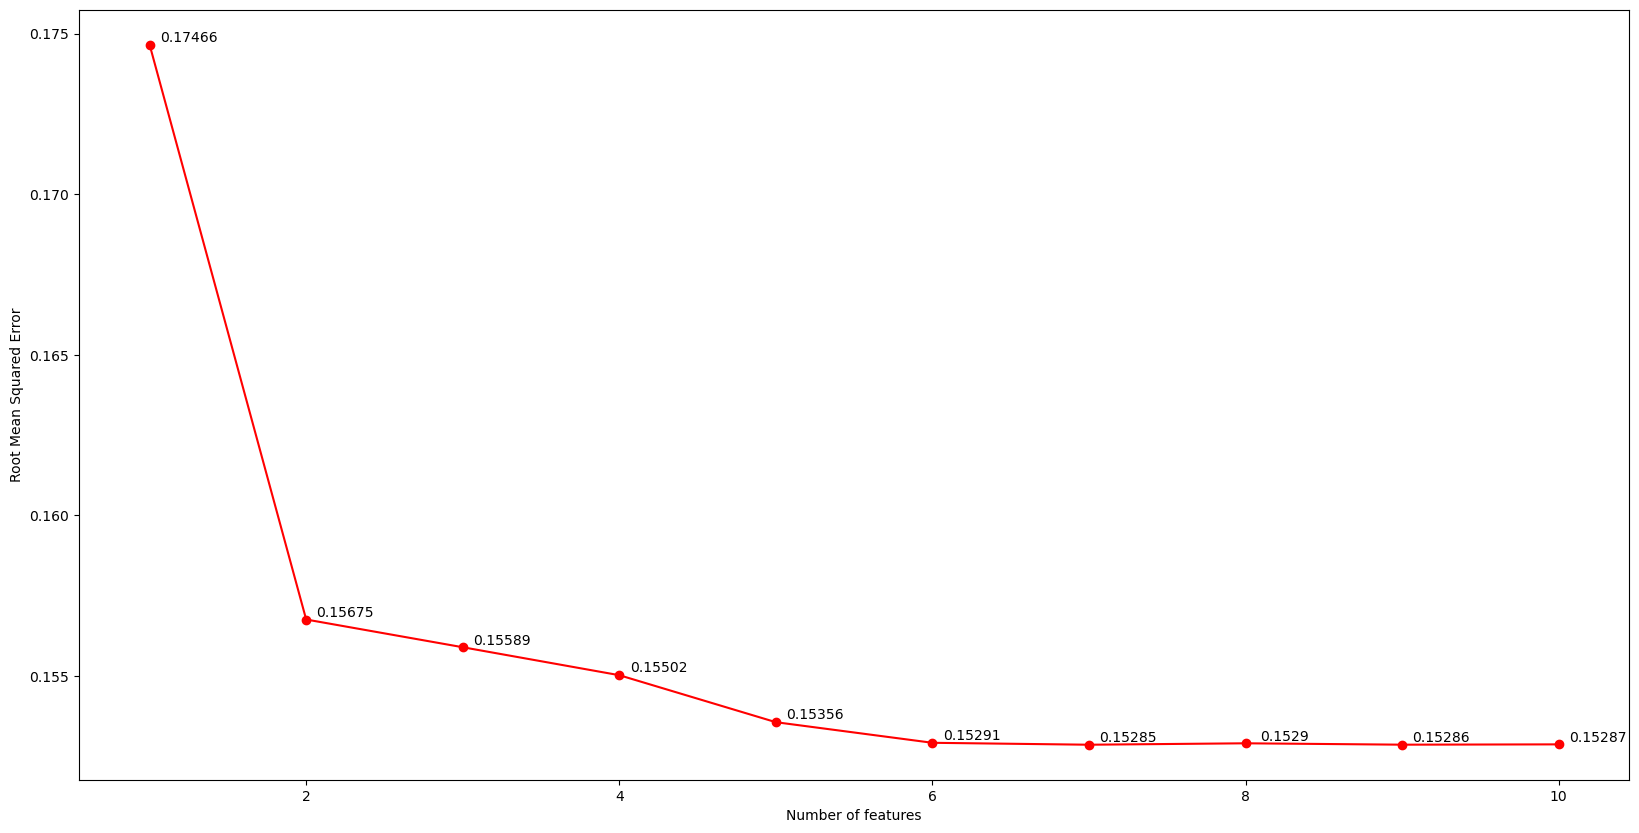

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the number of features
no_features = np.arange(1, X_train_processed.shape[1] + 1)

ax.plot(no_features, rmse_scores_list, marker='o', color='r')
plt.xlabel("Number of features")
plt.ylabel("Root Mean Squared Error")

for i, v in enumerate(rmse_scores_list):
    ax.text(i+1.25, v, round(v, 5), ha='center', va='bottom')
    
plt.show()

In [32]:
rfe_selector = RFE(estimator=gb, n_features_to_select=7, step=10)
rfe_selector.fit(X_train_processed, y_train)

selected_feats_array = rfe_selector.get_support()
selected_features = processor.get_feature_names_out()[selected_feats_array]

print("Selected Features:", selected_features)

Selected Features: ['num__Length' 'num__Height' 'num__Whole weight' 'num__Whole weight.1'
 'num__Whole weight.2' 'num__Shell weight' 'cat__Sex_I']


In [33]:
# Only selected features
X_train_selected = X_train_processed[:, selected_feats_array]

# Calculate the execution time
start_time = time.time()

# Fit the regressors with cross validation
xgb_cv = cross_val_score(xgb_reg, X_train_selected, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
catboost_cv = cross_val_score(catboost_reg, X_train_selected, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_cv = cross_val_score(lgbm_reg, X_train_selected, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

end_time = time.time()
print(f"\n\nExecution time with RFE features: {round(end_time - start_time, 2)} seconds")

Learning rate set to 0.079793
Learning rate set to 0.079793
Learning rate set to 0.079794
Learning rate set to 0.079793
Learning rate set to 0.079794
Learning rate set to 0.079794
Learning rate set to 0.079794
Learning rate set to 0.079794
0:	learn: 3.0493260	total: 64.8ms	remaining: 1m 4s
0:	learn: 3.0501817	total: 70.7ms	remaining: 1m 10s
1:	learn: 2.9354150	total: 72.8ms	remaining: 36.3s
0:	learn: 3.0535007	total: 68.4ms	remaining: 1m 8s
1:	learn: 2.9356901	total: 79ms	remaining: 39.4s
2:	learn: 2.8342549	total: 81.4ms	remaining: 27s
2:	learn: 2.8347758	total: 88.4ms	remaining: 29.4s
0:	learn: 3.0444520	total: 64.1ms	remaining: 1m 4s
1:	learn: 2.9387566	total: 80.2ms	remaining: 40s
3:	learn: 2.7449868	total: 96.3ms	remaining: 24s
1:	learn: 2.9305498	total: 74.9ms	remaining: 37.4s
3:	learn: 2.7477026	total: 101ms	remaining: 25.1s
2:	learn: 2.8387129	total: 93.4ms	remaining: 31.1s
0:	learn: 3.0497223	total: 70.3ms	remaining: 1m 10s
0:	learn: 3.0515965	total: 72.2ms	remaining: 1m 12s
4

In [34]:
cv_scores = [xgb_cv, catboost_cv, lgbm_cv]

# Convert negative RMSE values back to positive
cv_scores_positive = [-score for score in cv_scores]

# Calculate the mean of the positive RMSE scores
cv_mean = [round(np.mean(scores), 3) for scores in cv_scores_positive]

# Display as dataframe
rfe_features_rmse_scores = pd.DataFrame({"CV RMSE Mean": cv_mean}, index=[names for names in ["XGB", "CatBoost", "LightGBM"]])
rfe_features_rmse_scores.sort_values(by="CV RMSE Mean", ascending=False)

,CV RMSE Mean
XGB,1.870
LightGBM,1.858
CatBoost,1.846


## Feature set using Boruta selection

In [35]:
""" Error to be fixed
boruta = BorutaPy(
   estimator = gb, # Reuse the GradientBoostingRegressor 
   n_estimators = 'auto',
   max_iter = 100, # number of trials to perform
   random_state=SEED
)

boruta.fit(X_train_processed, y_train.values.ravel())

# Get the selected features
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()

print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
"""

" Error to be fixed\nboruta = BorutaPy(\n   estimator = gb, # Reuse the GradientBoostingRegressor \n   n_estimators = 'auto',\n   max_iter = 100, # number of trials to perform\n   random_state=SEED\n)\n\nboruta.fit(X_train_processed, y_train.values.ravel())\n\n# Get the selected features\ngreen_area = X_train.columns[boruta.support_].to_list()\nblue_area = X_train.columns[boruta.support_weak_].to_list()\n\nprint('features in the green area:', green_area)\nprint('features in the blue area:', blue_area)\n"

## Optuna

### CatBoost

In [36]:
def objective_cat(trial):
    param = {
        "iterations": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = CatBoostRegressor(**param, verbose=False, random_state=SEED)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_cat = optuna.create_study(direction='maximize', study_name='Cat Boosting')
study_cat.optimize(objective_cat, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"\n\nNumber of finished trials: {len(study_cat.trials)}")
print("Best trial:")
trial = study_cat.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.8928099042926665
  Params: 
    n_estimators: 946
    learning_rate: 0.09923379041929978
    colsample_bylevel: 0.0992819633225994
    min_data_in_leaf: 85
    depth: 4
    l2_leaf_reg: 1.0311033073131648
    boosting_type: Plain
    bootstrap_type: MVS



In [37]:
plot_optimization_history(study_cat)

In [38]:
plot_param_importances(study_cat)

In [39]:
plot_slice(study_cat)

In [40]:
def objective_cat(trial):
    param = {
        "iterations": trial.suggest_int("n_estimators", 100, 5000), # 3rd
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True), # Most important
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.001, 0.1, log=True), # 2nd
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 100, log=True), # Smaller scale
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"] # Remove one
        ),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.05, 1, log=True)

    model = CatBoostRegressor(**param, verbose=False, random_state=SEED)

    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_mean = np.mean(cv_scores)

    # Report the intermediate result to Optuna
    trial.report(cv_mean, step=1)

    # Prune the trial if the intermediate result is not promising
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return cv_mean


study_cat = optuna.create_study(direction='maximize', study_name='Cat Boosting 2')
study_cat.optimize(objective_cat, n_trials=100, n_jobs=-1, show_progress_bar=True)

cat_best_params = study_cat.best_params
cat_best_value = study_cat.best_value
trial = study_cat.best_trial

print(f"\n\nNumber of finished trials: {len(study_cat.trials)}")
print("Best trial:")
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.8631264891966253
  Params: 
    n_estimators: 3257
    learning_rate: 0.09731247786807815
    colsample_bylevel: 0.09621871163263937
    min_data_in_leaf: 10
    depth: 12
    l2_leaf_reg: 9.227164397396603
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 0.12007885613333591



### LightGBM

In [41]:
def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "boosting_type": trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        "num_leaves": trial.suggest_int('num_leaves', 2, 256),
        "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 16),
        "min_gain_to_split": trial.suggest_float('min_gain_to_split', 0, 15),
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.5, 1),
        "baggging_freq": trial.suggest_int('baggging_freq', 1, 10),
        "feature_fraction": trial.suggest_float('feature_fraction', 0.5, 1),
        "lambda_l1": trial.suggest_float('lambda_l1', 1e-8, 100),
        "lambda_l2": trial.suggest_float('lambda_l2', 1e-8, 100),
    }

    model = LGBMRegressor(**params, verbose=-1, random_state=SEED)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM')
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"\n\nNumber of finished trials: {len(study_lgbm.trials)}")
print("Best trial:")
trial = study_lgbm.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.8343130621400525
  Params: 
    n_estimators: 934
    max_depth: 11
    learning_rate: 0.037699778274133615
    boosting_type: gbdt
    num_leaves: 83
    min_child_samples: 90
    min_data_in_leaf: 7
    min_gain_to_split: 0.08436024905698458
    bagging_fraction: 0.7270480477278655
    baggging_freq: 2
    feature_fraction: 0.5553007402378273
    lambda_l1: 16.932174194593273
    lambda_l2: 37.44579854496997



In [42]:
plot_optimization_history(study_lgbm)

In [43]:
plot_param_importances(study_lgbm)

In [44]:
plot_slice(study_lgbm)

In [46]:
def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 1, 1000), # Most important
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True), # 2nd
        "boosting_type": 'gbdt', # Remove dart
        "num_leaves": trial.suggest_int('num_leaves', 2, 180), # Descrease the range
        "min_child_samples": trial.suggest_int('min_child_samples', 50, 100), # Descrease the range
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 5, 20), # Increase the range
        "min_gain_to_split": trial.suggest_float('min_gain_to_split', 0, 30), # 3rd
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.1, 0.8), 
        "baggging_freq": trial.suggest_int('baggging_freq', 1, 7), # Decrease the range
        "feature_fraction": trial.suggest_float('feature_fraction', 0.5, 0.8),
        "lambda_l1": trial.suggest_float('lambda_l1', 1e-8, 50), # Smaller scale
        "lambda_l2": trial.suggest_float('lambda_l2', 1e-8, 50), # Smaller scale
    }

    model = LGBMRegressor(**params, verbose=-1, random_state=SEED)

    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_mean = np.mean(cv_scores)

    # Report the intermediate result to Optuna
    trial.report(cv_mean, step=1)

    # Prune the trial if the intermediate result is not promising
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return cv_mean


study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM')
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

lgbm_best_params = study_lgbm.best_params
lgbm_best_value = study_lgbm.best_value
trial = study_lgbm.best_trial

print(f"\n\nNumber of finished trials: {len(study_lgbm.trials)}")
print("Best trial:")
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/100 [00:00<?, ?it/s]



Number of finished trials: 100
Best trial:
  Value: -1.8348807092858028
  Params: 
    n_estimators: 1864
    max_depth: 144
    learning_rate: 0.020689368759177377
    num_leaves: 158
    min_child_samples: 61
    min_data_in_leaf: 10
    min_gain_to_split: 0.608706452025638
    bagging_fraction: 0.6604277008873509
    baggging_freq: 2
    feature_fraction: 0.6484463071560206
    lambda_l1: 6.096374383431147
    lambda_l2: 4.8218929887931035



### XGBoost

In [61]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1, log=True),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    }

    model = XGBRegressor(**params, random_state=SEED, tree_method="hist", objective="reg:squaredlogerror", eval_metric="rmsle", n_jobs=8)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost')
study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1, show_progress_bar=True)

print(f"\n\nNumber of finished trials: {len(study_xgb.trials)}")
print("Best trial:")
trial = study_xgb.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_optimization_history(study_xgb)

In [ ]:
plot_param_importances(study_xgb)

In [ ]:
plot_slice(study_xgb)

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000), #  Increase the range
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.1, log=True), # Most important
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0.001, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10, log=True),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
    }

    model = XGBRegressor(**params, verbose=1, random_state=SEED)

    return np.mean(cross_val_score(model, X_train_processed, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1))


study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost')
study_xgb.optimize(objective_xgb, n_trials=50, n_jobs=-1, show_progress_bar=True)

xgb_best_params = study_xgb.best_params
xgb_best_value = study_xgb.best_value
trial = study_xgb.best_trial

print(f"\n\nNumber of finished trials: {len(study_xgb.trials)}")
print("Best trial:")
print(f"  Value: {trial.value}")
print("  Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

## Voting

In [ ]:
# Cat best params
# {'n_estimators': 3257, 'learning_rate': 0.09731247786807815, 'colsample_bylevel': 0.09621871163263937, 'min_data_in_leaf': 10, 'depth': 12, 'l2_leaf_reg': 9.227164397396603, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.12007885613333591}

# LGBM best params
# {'n_estimators': 1864, 'max_depth': 144, 'learning_rate': 0.020689368759177377, 'num_leaves': 158, 'min_child_samples': 61, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.608706452025638, 'bagging_fraction': 0.6604277008873509, 'baggging_freq': 2, 'feature_fraction': 0.6484463071560206, 'lambda_l1': 6.096374383431147, 'lambda_l2': 4.8218929887931035}

In [66]:
voting = [
    ("LightGBM", LGBMRegressor(**lgbm_best_params, random_state=SEED, n_jobs=-1)),
    ("CatBoost", CatBoostRegressor(**cat_best_params, random_state=SEED)),
    ("XGBoost", XGBRegressor(random_state=SEED, n_jobs=-1))
]

ensemble_model = VotingRegressor(
    estimators=voting,
    n_jobs=-1
)

cross_val_score(ensemble_model, X_train_selected, y_train, cv=fold, scoring='neg_root_mean_squared_error', n_jobs=-1)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/raydi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raydi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/raydi/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_voting.py", line 623, in fit
    return super().fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/raydi/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_voting.py", line 81, in fit
    names, clfs = self._validate_estimators()
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/raydi/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py", line 221, in _validate_estimators
    names, estimators = zip(*self.estimators)
                        ^^^^^^^^^^^^^^^^^^^^^
TypeError: 'LGBMRegressor' object is not iterable


# Evaluation

In [47]:
lgbm_reg = LGBMRegressor(**lgbm_best_params, random_state=SEED, n_jobs=-1, verbose=0)

lgbm_reg.fit(X_train_processed, y_train)
y_pred_lgbm = lgbm_reg.predict(X_test_processed)

print(f"LightGBM RMSE: {round(root_mean_squared_log_error(y_test, y_pred_lgbm), 5)}")

[LightGBM] [Warning] Unknown parameter: baggging_freq
[LightGBM] [Warning] lambda_l1 is set=6.096374383431147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.096374383431147
[LightGBM] [Warning] feature_fraction is set=0.6484463071560206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6484463071560206
[LightGBM] [Warning] bagging_fraction is set=0.6604277008873509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6604277008873509
[LightGBM] [Warning] lambda_l2 is set=4.8218929887931035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8218929887931035
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.608706452025638, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.608706452025638
[LightGBM] [Warning] Unknown parameter: baggging_freq
[LightGBM] [Warning] lambda_l1 is set=6.096374383431

In [50]:
xgb_reg = XGBRegressor(**xgb_best_params, random_state=SEED, n_jobs=-1)

xgb_reg.fit(X_train_processed, y_train)
y_pred_xgb = xgb_reg.predict(X_test_processed)

print(f"Root Mean Squared Log Error: {root_mean_squared_log_error(y_test, y_pred_xgb)}")

/Users/raydi/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:22:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "baggging_freq", "bagging_fraction", "boosting_type", "feature_fraction", "lambda_l1", "lambda_l2", "min_child_samples", "min_data_in_leaf", "min_gain_to_split", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Log Error: 0.166825487653443


In [48]:
catboost_reg = CatBoostRegressor(**cat_best_params, verbose=False, random_state=SEED)

# Fit to predict
catboost_reg.fit(X_train_processed, y_train)
y_pred_cat = catboost_reg.predict(X_test_processed)

# RMSE
print(f"CatBoost RMSLE: {root_mean_squared_log_error(y_test, y_pred_cat)}")

CatBoost RMSLE: 0.15072960909695382


# Prediction & Submission

In [50]:
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [51]:
to_pred = test.drop('id', axis=1)

to_pred_processed = processor.transform(to_pred)


In [53]:
predictions = catboost_reg.predict(to_pred_processed)
sub["Rings"] = predictions
sub.to_csv("submission.csv", index=False)

# Reference

* [Feature selection in machine learning | Full course](https://www.youtube.com/watch?v=hCwTDTdYirg&t=2331s&ab_channel=DataSciencewithMarco)
* [Towards Data Science | Boruta](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)
* [Kapturov's solution of PS S4E4](https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e4#%F0%9F%90%9A-Define-base-models)
* [Beginner’s Guide to the Must-Know LightGBM Hyperparameters](https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702)
* [XGBoost Hyperparameter Tuning With Optuna (Kaggle Grandmaster Guide)](https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/)
* [Clean Code | Voting Regressor base 3 Models](https://www.kaggle.com/code/mfmfmf3/clean-code-voting-regressor-base-3-models/notebook)